In [1]:
import time
import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import signal
import os, errno
import glob

## compute kinematic paramters - velocity (speed and angular velocity)

In [3]:
# load centroid file wih distance and centroid data

df = pd.read_csv('./dataFolders/Output/KinematicAnalysis_Final/LowPassFiltered_CentroidAndDistanceData.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_filtered,y_filtered,cent_x,cent_y,distance,distanceincms
0,0,0,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,L0.1_c-3_m10,last,74,310,233,0.810811,2.297297,24.0,68.0,23.997467,67.98341,-286.002533,-165.01659,330.193767,11.155195
4,4,4,L0.1_c-3_m10,last,74,310,233,1.013514,2.770270,30.0,82.0,24.708767,143.71776,-285.291233,-89.28224,298.935455,10.099171


In [4]:
# remove Problematic Files

listProbs = pd.read_csv(r'G:\My Drive\Mahad\Light Level Experiments\Data Output from Analysis\VideosWithMarkers\FirstLastTroubleVideos_v4\names.csv')
listProbs['name'] = listProbs['name'].str[1:]
listProbs.head()

# df.name.str.contains(df.name + '_' + df.visitNum)

,Unnamed: 0,name
0,0,L0.1_c-3_m10_firstVisit.csv
1,1,L0.1_c-3_m10_lastVisit.csv
2,2,L0.1_c-3_m12_firstVisit.csv
3,3,L0.1_c-3_m12_lastVisit.csv
4,4,L0.1_c-3_m23_lastVisit.csv


In [5]:
df['string'] = df.name + '_' + df.visit + 'Visit.csv'

sub_df= df[pd.DataFrame(df.string.tolist()).isin(listProbs.name.tolist()).any(1) == False]

In [6]:
sub_df.head()

,Unnamed: 0,Unnamed: 0.1,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_filtered,y_filtered,cent_x,cent_y,distance,distanceincms,string
2818,2818,2818,L0.1_c-3_m2,first,74,309,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2819,2819,2819,L0.1_c-3_m2,first,74,309,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2820,2820,2820,L0.1_c-3_m2,first,74,309,233,14.054054,16.216216,416.0,480.0,415.991725,479.978923,106.991725,246.978923,269.157608,9.093162,L0.1_c-3_m2_firstVisit.csv
2821,2821,2821,L0.1_c-3_m2,first,74,309,233,12.027027,15.777027,356.0,467.0,425.584860,471.956375,116.584860,238.956375,265.880008,8.982433,L0.1_c-3_m2_firstVisit.csv
2822,2822,2822,L0.1_c-3_m2,first,74,309,233,17.398649,15.810811,515.0,468.0,422.540000,464.678111,113.540000,231.678111,258.004028,8.716352,L0.1_c-3_m2_firstVisit.csv


In [7]:
df_use = sub_df.copy()
df_use[['lightLevel', 'mothID']] =  df_use['name'].str.split('_', n = 1, expand = True)
df_use = df_use.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 
                                'name',
                                'flower_x', 'flower_y',
                                'x', 'y',
#                                 'x_pixel', 'y_pixel',
                                'distance', 'distanceincms',
                                'string'
                                ])

In [8]:
df_use.head()

,visit,flower_r,x_pixel,y_pixel,x_filtered,y_filtered,cent_x,cent_y,lightLevel,mothID
2818,first,74,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2819,first,74,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2820,first,74,416.0,480.0,415.991725,479.978923,106.991725,246.978923,L0.1,c-3_m2
2821,first,74,356.0,467.0,425.584860,471.956375,116.584860,238.956375,L0.1,c-3_m2
2822,first,74,515.0,468.0,422.540000,464.678111,113.540000,231.678111,L0.1,c-3_m2


In [9]:
outfig = r'./dataFolders/Output/KinematicAnalysis_Final/Figures/IndividualMoths/LowPass_filteredPosition/'

In [10]:
def figureFiltered(original, filtered, ax):
    ax = ax.ravel()

    ax[0].plot(original.x_pixel)
    ax[0].plot(filtered.x)
    ax[0].set_title('x position (cm)')

    ax[1].plot(original.y_pixel)
    ax[1].plot(filtered.y)
    ax[1].set_title('y position (cm)')

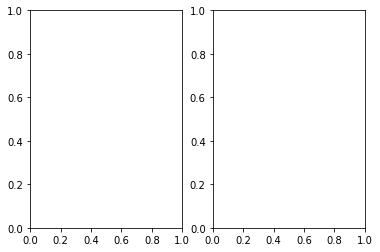

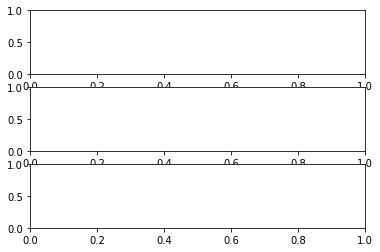

In [11]:
velocity = []
acceleration = []
light = []
visit = []
mothID = []

f0, ax0 = plt.subplots(1,2)

f1, ax1 = plt.subplots(3,1)
ax1 = ax1.ravel()

for l, light_sub in df_use.groupby('lightLevel'):
    for v, visit_sub in light_sub.groupby('visit'):
        for m, moth_sub in visit_sub.groupby('mothID'):

            filtered = pd.DataFrame({'x': moth_sub.x_filtered*2.5/moth_sub.flower_r , 
                                    'y': moth_sub.y_filtered*2.5/moth_sub.flower_r})
            
            figureFiltered(moth_sub, filtered, ax0)
            f0.savefig(outfig + m + '.pdf')
            for axes in ax0:
                axes.cla()
            
            filtered.x  = filtered.x*2.5/moth_sub.flower_r.unique()
            filtered.y  = filtered.y*2.5/moth_sub.flower_r.unique()
            
            x_vel = np.gradient(filtered.x)
            x_acc = np.gradient(x_vel)
            y_vel = np.gradient(filtered.y)
            y_acc = np.gradient(y_vel)
            filtered.index = filtered.index*1/100
            
            vel = np.sqrt(x_vel**2 + y_vel**2)
            acc = np.sqrt(x_acc**2 + y_acc**2)
        
            light.extend([l]*len(vel))
            visit.extend([v]*len(vel))
            mothID.extend([m]*len(vel))
            velocity.extend(vel)
            acceleration.extend(acc)
            
            # plot shit
            ax1[0].plot(filtered.x)
            ax1[0].plot(filtered.y)
            ax1[0].set_ylabel('position (cm)')
            
            ax1[1].plot(x_vel)
            ax1[1].plot(y_vel)
            ax1[1].plot(vel, alpha = 0.5)
            ax1[1].set_ylabel('velocity\n ($x^{-2} cm/s$)')
            
            ax1[2].plot(x_acc)
            ax1[2].plot(y_acc)
            ax1[2].plot(acc, alpha = 0.5)
            ax1[2].set_ylabel('acceleration\n ($x^{-4} cm/s^2$)')
            
            f1.savefig('./dataFolders/Output/KinematicAnalysis_Final/Figures/velocity/' + 
                    l + '_' + m + '_' + v + '_velocity.pdf', bbox_inches = 'tight')
            for axes in ax1:
                axes.cla()

In [12]:
final = pd.DataFrame({'lightLevel': light,
                     'visit': visit,
                     'mothID':mothID,
                     'velocity':velocity,
                     'acceleration': acceleration})

In [13]:
final.head()

,lightLevel,visit,mothID,velocity,acceleration
0,L0.1,first,c-3_m2,NaN,NaN
1,L0.1,first,c-3_m2,NaN,NaN
2,L0.1,first,c-3_m2,NaN,NaN
3,L0.1,first,c-3_m2,0.009498,NaN
4,L0.1,first,c-3_m2,0.013041,0.01065


In [14]:
mothID = []
visit = []
lightLevel = []
median_velocity = []
median_acc = []

for l, light_sub in final.groupby('lightLevel'):
    for v, visit_sub in light_sub.groupby('visit'):
        for m, moth_sub in visit_sub.groupby('mothID'):
            mean_v = np.nanmedian(moth_sub.velocity)
            mean_a = np.nanmedian(moth_sub.acceleration)
            
            median_velocity.append(mean_v)
            median_acc.append(mean_a)
            mothID.append(m)
            visit.append(v)
            lightLevel.append(l)
            
summary = pd.DataFrame({'lightLevel': lightLevel,
                       'visit': visit,
                       'mothID': mothID,
                       'median_velocity': median_velocity,
                       'median_acc': median_acc})

In [15]:
summary

,lightLevel,visit,mothID,median_velocity,median_acc
0,L0.1,first,c-3_m2,0.003173,0.001536
1,L0.1,first,c-3_m20,0.004449,0.002606
2,L0.1,first,c-3_m21,0.005255,0.003732
3,L0.1,first,c-3_m22,0.006052,0.004071
4,L0.1,first,c-3_m23,0.005908,0.003117
...,...,...,...,...,...
70,L50,last,c-3_m37,0.006039,0.003127
71,L50,last,c-3_m38,0.004349,0.002567
72,L50,last,c-3_m39,0.006592,0.003662
73,L50,last,c-3_m45,0.005582,0.004086


In [16]:
# convert everything to m/s or m/s^2

# velocity (m/s) = velocity (10^-2 cm/s) * 10^2 (100 frames per second)
# same for acceleration
# summary.median_velocity = summary.median_velocity
# summary.median_acc = summary.median_acc

In [17]:
summary.to_csv(r'./dataFolders/Output/KinematicAnalysis_Final/MothCentricVelocity.csv')

In [18]:
summary.groupby('visit').mean()

,median_velocity,median_acc
visit,,
first,0.005152,0.00290
last,0.005745,0.00307


In [55]:
colorScheme = {'L0.1':plt.cm.Purples_r, 'L50':plt.cm.Oranges_r}

In [56]:
import seaborn as sns
sns.set(style="ticks")
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 8

w = 7/2
# w = 8
h = w * 2

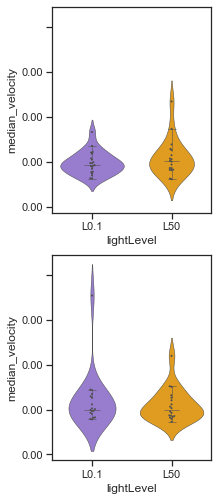

In [77]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0
for v, sub in summary.groupby('visit'):
    sns.violinplot(x='lightLevel', y='median_velocity', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='median_velocity', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='median_velocity', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])
    i+=1
plt.tight_layout()

for axes in ax:
    axes.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in axes.get_yticklabels()[1:-1]])
        
f.savefig('./dataFolders/Output/KinematicAnalysis_Final/Figures/mothCentricVelocity_withoutLabels.pdf')

In [76]:
for t in axes.get_yticklabels()[1:-1]:
#     print(t)
    print(float(t.get_text()))

0.0
5e-07
1e-06
1.5e-06
2e-06


In [44]:
low_first = summary[(summary.lightLevel == 'L0.1') & (summary.visit == 'first')].median_velocity.values
high_first = summary[(summary.lightLevel == 'L50') & (summary.visit == 'first')].median_velocity.values

low_last = summary[(summary.lightLevel == 'L0.1') & (summary.visit == 'last')].median_velocity.values
high_last = summary[(summary.lightLevel == 'L50') & (summary.visit == 'last')].median_velocity.values

In [45]:
from scipy import stats

stats.mannwhitneyu(low_first, high_first)

MannwhitneyuResult(statistic=161.0, pvalue=0.21925116633133757)

In [33]:
stats.mannwhitneyu(low_last, high_last)

MannwhitneyuResult(statistic=155.0, pvalue=0.4185318077449268)

In [34]:
stats.ks_2samp(low_first, high_first)

Ks_2sampResult(statistic=0.2222222222222222, pvalue=0.6486347137235615)

In [35]:
stats.ks_2samp(low_last, high_last)

Ks_2sampResult(statistic=0.16666666666666666, pvalue=0.9715397823325015)

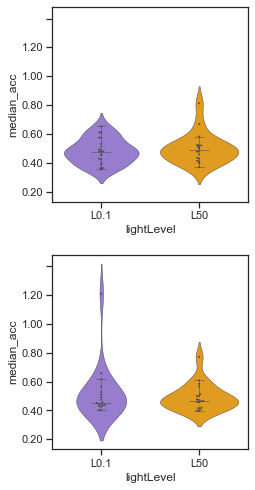

In [78]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0
for v, sub in summary.groupby('visit'):
    sns.violinplot(x='lightLevel', y='median_acc', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='median_acc', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='median_acc', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])
    i+=1
plt.tight_layout()

for axes in ax:
    axes.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in axes.get_yticklabels()[1:-1]])

f.savefig('./dataFolders/Output/KinematicAnalysis_Final/Figures/mothCentricAcceleration_withoutLabels.pdf')

In [37]:
low_first = summary[(summary.lightLevel == 'L0.1') & (summary.visit == 'first')].median_acc.values
high_first = summary[(summary.lightLevel == 'L50') & (summary.visit == 'first')].median_acc.values

low_last = summary[(summary.lightLevel == 'L0.1') & (summary.visit == 'last')].median_acc.values
high_last = summary[(summary.lightLevel == 'L50') & (summary.visit == 'last')].median_acc.values

print(stats.mannwhitneyu(low_first, high_first))
print(stats.mannwhitneyu(low_last, high_last))

print(stats.ks_2samp(low_first, high_first))
print(stats.ks_2samp(low_last, high_last))

MannwhitneyuResult(statistic=170.0, pvalue=0.30112122997933066)
MannwhitneyuResult(statistic=159.0, pvalue=0.46847793383497877)
Ks_2sampResult(statistic=0.16666666666666666, pvalue=0.9100418854707246)
Ks_2sampResult(statistic=0.2222222222222222, pvalue=0.7810478607409853)


In [19]:
summary = pd.read_csv('./dataFolders/Output/KinematicAnalysis_Final/MothCentricVelocity.csv')
summary.head()

,Unnamed: 0,lightLevel,visit,mothID,median_velocity,median_acc
0,0,L0.1,first,c-3_m2,0.003173,0.001536
1,1,L0.1,first,c-3_m20,0.004449,0.002606
2,2,L0.1,first,c-3_m21,0.005255,0.003732
3,3,L0.1,first,c-3_m22,0.006052,0.004071
4,4,L0.1,first,c-3_m23,0.005908,0.003117


In [20]:
for v, test_df in summary.groupby('visit'):
    for t, final in test_df.groupby('lightLevel'):
        l = len(final.mothID.unique())
        print('Num of moths for %s and %s is %i' %(v, t, l))

Num of moths for first and L0.1 is 21
Num of moths for first and L50 is 18
Num of moths for last and L0.1 is 18
Num of moths for last and L50 is 18


## plot the distribution as box plots

In [11]:
import seaborn as sns

In [23]:
summary = pd.read_csv('./dataFolders/Output/KinematicAnalysis_Final/MothCentricVelocity.csv')
# fix the exponents - 
summary['median_velocity'] = summary['median_velocity']*1e4
summary['median_acc'] = summary['median_acc']*1e6
summary.head()

,Unnamed: 0,lightLevel,visit,mothID,median_velocity,median_acc
0,0,L0.1,first,c-3_m2,0.003173,0.001536
1,1,L0.1,first,c-3_m20,0.004449,0.002606
2,2,L0.1,first,c-3_m21,0.005255,0.003732
3,3,L0.1,first,c-3_m22,0.006052,0.004071
4,4,L0.1,first,c-3_m23,0.005908,0.003117


In [24]:
summary.groupby('visit').mean()

,Unnamed: 0,median_velocity,median_acc
visit,,,
first,27.307692,0.005152,0.00290
last,47.500000,0.005745,0.00307


In [25]:
summary.to_csv(r'./dataFolders/Output/KinematicAnalysis_Final/MothCentricVelocity.csv')

In [6]:
#define the colors for low and high light levels
mc = {'L0.1': 'black', 'L50':'grey' }
c = {'L0.1': 'mediumpurple', 'L50':'darkorange'}
boxprops = {'edgecolor': 'k', 'linewidth': 2,'alpha': 1}
lineprops = {'color': 'k', 'linewidth': 2}
capprops = {'linewidth': 0}

bkwargs = {'palette': c, 'order': ['L0.1', 'L50']}
skwargs =  {'palette': mc, 'order': ['L0.1', 'L50']}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': capprops,
                       'width': 0.4},
                      **bkwargs)
stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.8},
                        **skwargs)

In [20]:
w = 7/2
h = w * 2

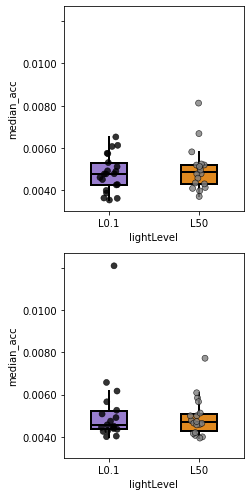

In [21]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)
i=0
for v, sub in summary.groupby('visit'):
    sns.boxplot(ax = ax[i], x='lightLevel', y='median_acc', data = sub, 
                fliersize=0, **boxplot_kwargs)
    sns.stripplot(ax= ax[i], x='lightLevel', y='median_acc', data = sub,
                 dodge=True, **stripplot_kwargs)
    i+=1
plt.tight_layout()

for axes in ax:
    axes.set_yticklabels(['{:.4f}'.format(float(t.get_text())) for t in axes.get_yticklabels()[1:-1]])

f.savefig('./dataFolders/Output/KinematicAnalysis_Final/Figures/mothCentricAcceleration_boxPlots.pdf')

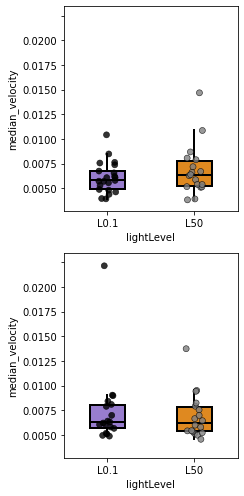

In [17]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)
i=0
for v, sub in summary.groupby('visit'):
    sns.boxplot(ax = ax[i], x='lightLevel', y='median_velocity', data = sub, 
                fliersize=0, **boxplot_kwargs)
    sns.stripplot(ax= ax[i], x='lightLevel', y='median_velocity', data = sub,
                 dodge=True, **stripplot_kwargs)
    i+=1
plt.tight_layout()

for axes in ax:
    axes.set_yticklabels(['{:.4f}'.format(float(t.get_text())) for t in axes.get_yticklabels()[1:-1]])

f.savefig('./dataFolders/Output/KinematicAnalysis_Final/Figures/mothCentricVelocity_boxPlots.pdf')